In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import seaborn as sns
import sys
import squidpy as sq

# sys.path.append("/home/icb/giovanni.palla/code/spatial-alignment/data")
# from data.simulated.generate_twod_data import generate_twod_data_partial_overlap

%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
adata = sc.read(
    "/lustre/groups/ml01/workspace/giovanni.palla/moscot/data/alignment.h5ad"
)

adata = adata[adata.obs.synth_batch == "6"].copy()
# sc.pp.subsample(adata, fraction=0.8)
adata

/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 3200 × 500
    obs: 'batch', 'idx', 'synth_batch'
    obsm: 'spatial'

In [3]:
from moscot.problems.space import AlignmentProblem

ap = AlignmentProblem(adata).prepare(batch_key="batch")

2023-01-06 12:45:08.339013: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64
2023-01-06 12:45:14.334472: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64
2023-01-06 12:45:14.674926: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dyn

INFO     Normalizing spatial coordinates and saving them in `adata.obsm['spatial_norm']`.                          
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  


In [4]:
ap = ap.solve()

INFO     Solving problem OTProblem[stage='prepared', shape=(1600, 1600)].                                          
WARNING  Solver did not converge                                                                                   


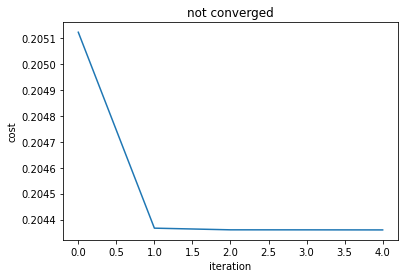

In [5]:
ap[(0, 1)].solution.plot_convergence()

In [51]:
tmap = np.array(ap[(0, 1)].solution.transport_matrix)
tmap = tmap / tmap.sum(0)

In [52]:
batch1 = adata[adata.obs.batch == 0].copy()
batch2 = adata[adata.obs.batch == 1].copy()
out = (batch1.obsm["spatial"].T @ tmap).T

In [37]:
ap[(0, 1)].solution.transport_matrix

DeviceArray([[5.4697087e-04, 2.9963143e-05, 1.8515011e-09, ...,
              0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
             [1.6055867e-05, 5.3512619e-04, 2.2177897e-05, ...,
              0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
             [2.5335500e-10, 5.6714398e-06, 5.7327060e-04, ...,
              0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
             ...,
             [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
              5.4954545e-04, 2.1642247e-06, 2.2397202e-11],
             [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
              5.3725696e-05, 5.6048314e-04, 5.6107724e-06],
             [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
              3.3749625e-09, 3.4078297e-05, 5.8693555e-04]],            dtype=float32)

In [32]:
out = ap[(0, 1)].solution.push(batch1.obsm["spatial_norm"], scale_by_marginals=True)

In [53]:
batch1.obsm["spatial_warp"] = batch1.obsm["spatial"]
batch2.obsm["spatial_warp"] = out
import anndata as ad

adata_temp = ad.concat([batch1, batch2])

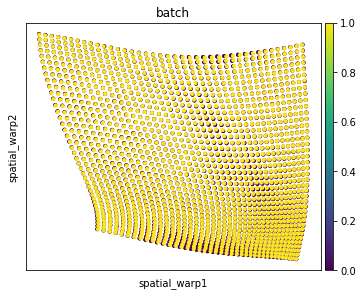

In [54]:
sq.pl.spatial_scatter(adata_temp, shape=None, color="batch", spatial_key="spatial_warp")

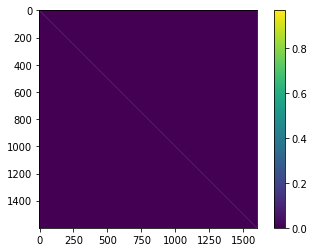

In [57]:
plt.imshow(tmap)
plt.colorbar()

In [58]:
tmap.max()

0.96669436

/home/icb/giovanni.palla/code/squidpy/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


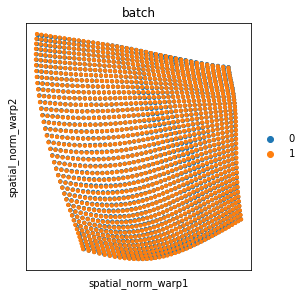

In [26]:
sq.pl.spatial_scatter(adata, shape=None, color="batch", spatial_key="spatial_norm_warp")

In [28]:
from sklearn.metrics import mean_squared_error

ad1 = adata[adata.obs.batch == 0].copy()
ad2 = adata[adata.obs.batch == 1].copy()

_, comm1, comm2 = np.intersect1d(ad1.obs.idx, ad2.obs.idx, return_indices=True)

test_results = {}
mean_squared_error(
    ad1.obsm["spatial_norm_warp"][comm1], ad2.obsm["spatial_norm_warp"][comm2]
)

5.5208535709569563e-05

In [29]:
adata

AnnData object with n_obs × n_vars = 3200 × 500
    obs: 'batch', 'idx', 'synth_batch'
    uns: 'batch_colors'
    obsm: 'spatial', 'spatial_norm', 'spatial_norm_warp'